In [1]:
import cv2
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from scipy.ndimage import gaussian_gradient_magnitude
from skimage.util import view_as_blocks
from skimage.filters import gabor
from sklearn.preprocessing import normalize
import scipy.linalg
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import os

In [12]:
PATCH_SIZE_DEF = (32, 32)

# Functions

## Helper functions

In [3]:
def list_all_img_files(folder_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png"):
    real_image_paths = []
    generated_image_paths = []
    
    for file in os.listdir(folder_path):
        if file.endswith(real_postfix):
            real_image_paths.append(os.path.join(folder_path, file))
        elif file.endswith(fake_postfix):
            generated_image_paths.append(os.path.join(folder_path, file))
    
    return sorted(real_image_paths), sorted(generated_image_paths)

## Enhanced VFFD functions

In [4]:
def safe_skew(data):
    return skew(data) if np.std(data) > 1e-6 else 0.0

def safe_kurtosis(data):
    return kurtosis(data) if np.std(data) > 1e-6 else -3.0  # normal dist baseline

def safe_entropy(hist):
    hist += 1e-8  # avoid log(0)
    hist /= hist.sum()
    return entropy(hist)

def extract_patch_stats(image, patch_size=(8, 8)):
    if PATCH_SIZE_DEF:
        patch_size = PATCH_SIZE_DEF
    blocks = view_as_blocks(image, block_shape=patch_size)
    features = []

    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            patch = blocks[i, j].flatten()

            f_mean = np.mean(patch)
            f_std = np.std(patch)
            f_skew = safe_skew(patch)
            f_kurt = safe_kurtosis(patch)
            hist = np.histogram(patch, bins=32, range=(0, 1), density=True)[0]
            f_entropy = safe_entropy(hist)

            features.extend([f_mean, f_std, f_skew, f_kurt, f_entropy])

    return np.array(features)

In [5]:
def extract_gradient_features(image):
    """
    Compute gradient magnitude and return distributional features.
    """
    grad_mag = gaussian_gradient_magnitude(image, sigma=1)
    grad_flat = grad_mag.flatten()

    return np.array([
        np.mean(grad_flat),
        np.std(grad_flat),
        skew(grad_flat),
        kurtosis(grad_flat),
        entropy(np.histogram(grad_flat, bins=32, density=True)[0] + 1e-8)
    ])


def extract_gabor_texture(image):
    """
    Apply Gabor filter and return texture-based features.
    """
    filt_real, _ = gabor(image, frequency=0.2)
    filt_flat = filt_real.flatten()

    return np.array([
        np.mean(filt_flat),
        np.std(filt_flat),
        skew(filt_flat),
        kurtosis(filt_flat),
        entropy(np.histogram(filt_flat, bins=32, density=True)[0] + 1e-8)
    ])


def extract_advanced_velocity_features(image_path):
    """
    Combine patch-level stats, gradient features, and texture features into a single vector.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0

    patch_feats = extract_patch_stats(img)
    grad_feats = extract_gradient_features(img)
    gabor_feats = extract_gabor_texture(img)

    feature_vector = np.concatenate([patch_feats, grad_feats, gabor_feats])
    feature_vector = np.nan_to_num(feature_vector, nan=0.0, posinf=1.0, neginf=-1.0)
    feature_vector = normalize(feature_vector.reshape(1, -1))[0]  # Normalize the vector

    return feature_vector


def enhanced_vffd(real_img_path, gen_img_path):
    """
    Compute Fréchet Distance between enriched statistical features of real and generated velocity images.
    """
    real_features = extract_advanced_velocity_features(real_img_path)
    gen_features = extract_advanced_velocity_features(gen_img_path)

    mu_real, mu_gen = real_features, gen_features
    sigma_real = np.diag(np.var(real_features, ddof=1) * np.ones(len(real_features)))
    sigma_gen = np.diag(np.var(gen_features, ddof=1) * np.ones(len(gen_features)))

    mean_diff = np.sum((mu_real - mu_gen) ** 2)
    cov_sqrt, _ = scipy.linalg.sqrtm(sigma_real @ sigma_gen, disp=False)

    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    frechet_distance = mean_diff + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    return frechet_distance

def average_enhanced_vffd(real_image_paths, generated_image_paths, verbose=False):
    avg_enhanced_vffd = 0
    print_step = 10
    n = len(real_image_paths)
    for i in range(n):
        if (i % print_step) == 0 and verbose:
            print(f"img {i}/{n}...")
        avg_enhanced_vffd += enhanced_vffd(real_image_paths[i], generated_image_paths[i])

    return avg_enhanced_vffd / n

# Dataset evaluation

## Labels to facades

In [ ]:
result_path = "./results/facades_label2photo_pretrained_pix2pix/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("facades_label2photo_pretrained_pix2pix:", avg_e_vffd)

In [ ]:
result_path = "./results/facades_label2photo_pretrained_CycleGAN/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real.png", fake_postfix="_fake.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("facades_label2photo_pretrained_CycleGAN:", avg_e_vffd)

In [ ]:
result_path = "./results/facades_label2photo_pureUNET/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("facades_label2photo_pretrained_pureUNET:", avg_e_vffd)

## Wind tunnel

In [ ]:
result_path = "./results/windtunnel_pureUNET/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_A.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("windtunnel_pureUNET:", avg_e_vffd)

In [ ]:
result_path = "./results/windtunnel_CycleGAN/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="real_A.png", fake_postfix="fake_A.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("windtunnel_CycleGAN:", avg_e_vffd)

In [ ]:
result_path = "./results/windtunnel_pix2pix/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("windtunnel_pix2pix:", avg_e_vffd)

## Map2sat

In [ ]:
result_path = "./results/map2sat_pureUNET/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("map2sat_pretrained_pureUNET:", avg_e_vffd)

In [ ]:
result_path = "./results/map2sat_pretrained_CycleGAN/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_A_real.png", fake_postfix="_A_fake.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("map2sat_pretrained_CycleGAN:", avg_e_vffd)

In [ ]:
result_path = "./results/map2sat_pretrained_pix2pix/test_latest/images"

real_image_paths, generated_image_paths = list_all_img_files(result_path, real_postfix="_real_B.png", fake_postfix="_fake_B.png")

avg_e_vffd = average_enhanced_vffd(real_image_paths, generated_image_paths)
print("map2sat_pretrained_pix2pix:", avg_e_vffd)

# Experiments and visualizations

In [13]:
v_mag_img_path_fake = "results/windtunnel_pix2pix/test_latest/images/20240415_125028_joined_fake_B.png"
v_mag_img_path_real = "results/windtunnel_pix2pix/test_latest/images/20240415_125028_joined_real_B.png"

v_mag_img_path_fake = "results/windtunnel_pix2pix/test_latest/images/20240415_160914_joined_real_B.png"
v_mag_img_path_real = "results/windtunnel_pix2pix/test_latest/images/20240415_160914_joined_fake_B.png"

v_mag_img_path_fake = "results/windtunnel_pureUNET/test_latest/images/20240415_160914_joined_fake_B.png"
v_mag_img_path_real = "results/windtunnel_pureUNET/test_latest/images/20240415_160914_joined_real_A.png"

# v_mag_img_path_fake = "results/windtunnel_CycleGAN/test_latest/images/20240526_194709_flowfield_real_A.png"
# v_mag_img_path_real = "results/windtunnel_CycleGAN/test_latest/images/20240526_194709_flowfield_fake_A.png"

### Grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


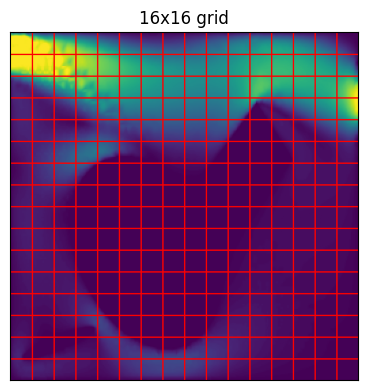

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


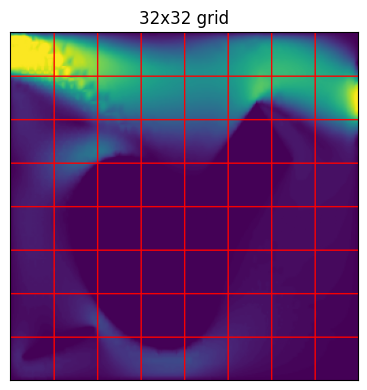

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


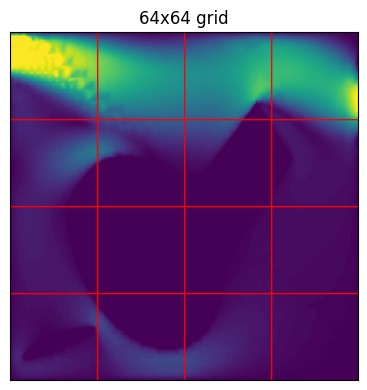

In [14]:
paths = [v_mag_img_path_fake, v_mag_img_path_real]
labels = ["Fake", "Real"]
grid_sizes = [16, 32, 64]  # Grid cell sizes

if len(paths) != len(labels):
    print("ERROR: length of labels should be same as length of paths!!!")
    exit(1)

# Function to overlay red grid on color image
def overlay_grid(img, grid_size):
    height, width, _ = img.shape  # Note: Now handling 3 channels for color
    img_with_grid = img.copy()
    
    # Calculate how many pixels correspond to one grid cell
    cell_height = height / grid_size
    cell_width = width / grid_size
    
    red_color = (255, 0, 0)
    
    for i in range(1, grid_size):
        x = int(i * cell_width)
        cv2.line(img_with_grid, (x, 0), (x, height-1), red_color, 1)
    
    for i in range(1, grid_size):
        y = int(i * cell_height)
        cv2.line(img_with_grid, (0, y), (width-1, y), red_color, 1)
    
    return img_with_grid

for i, v_mag_img_path in enumerate([paths[1]]):
    original_img = cv2.imread(v_mag_img_path, cv2.IMREAD_COLOR).astype(np.float32)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    original_img = original_img / 255.0
    
    for j, grid_size_orig in enumerate(grid_sizes):
        plt.figure(figsize=(4, 4))
        
        grid_size = int(256/grid_size_orig)
        
        img_with_grid = overlay_grid(original_img, grid_size)
        
        plt.imshow(img_with_grid)
        plt.title(f"{grid_size_orig}x{grid_size_orig} grid")
        plt.xticks([])
        plt.yticks([])
        
        plt.tight_layout()
        plt.show()

## Experiments with different images

### Noisy

In [15]:
def add_gaussian_noise(image, mean=0, sigma=0.1):
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

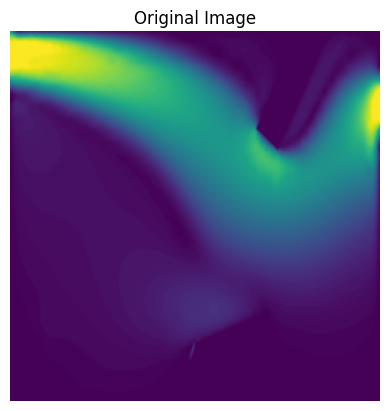

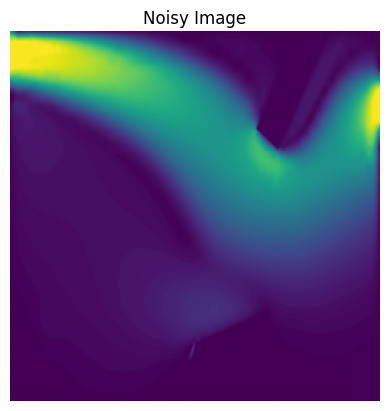

Calling enhanced_vffd function...
Enhanced VFFD score: 0.28005 with patch size (32, 32)


In [22]:
img_path_original = 'experimental/windtunnel_20240415_125028_real_B.png'
img_path_noisy = 'experimental/windtunnel_20240415_125028_real_B_noisy.png'
labels = ["Original", "Noisy"]

original_img = cv2.imread(img_path_original, cv2.IMREAD_COLOR).astype(np.float32)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = original_img / 255.0

plt.figure()
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

noisy_img = add_gaussian_noise(original_img, mean=0, sigma=0.001)

noisy_img_bgr = cv2.cvtColor((noisy_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
cv2.imwrite(img_path_noisy, noisy_img_bgr)

noisy_img_read = cv2.imread(img_path_noisy, cv2.IMREAD_COLOR).astype(np.float32)
noisy_img_read = cv2.cvtColor(noisy_img_read, cv2.COLOR_BGR2RGB)
noisy_img_read = noisy_img_read / 255.0

plt.figure()
plt.imshow(noisy_img_read)
plt.title("Noisy Image")
plt.axis('off')
plt.show()

paths = [img_path_original, img_path_noisy]

if len(paths) != len(labels):
    print("ERROR: length of labels should be same as length of paths!!!")
    exit(1)

print("Calling enhanced_vffd function...")
print(f"Enhanced VFFD score: {round(enhanced_vffd(img_path_original, img_path_noisy), 5)} with patch size {PATCH_SIZE_DEF}")

### Grayscale

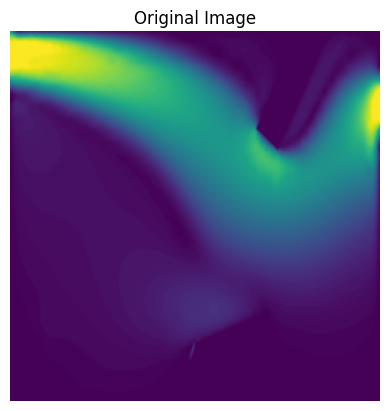

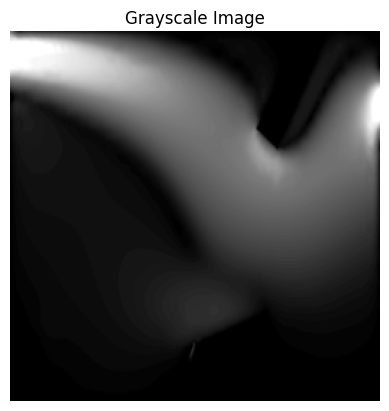

Calling enhanced_vffd function...
Enhanced VFFD score: 0.0 with patch size (32, 32)


In [24]:
img_path_original = 'experimental/windtunnel_20240415_125028_real_B.png'
img_path_grayscale = 'experimental/windtunnel_20240415_125028_real_B_gray.png'
labels = ["Original", "Grayscale"]

original_img = cv2.imread(img_path_original, cv2.IMREAD_COLOR).astype(np.float32)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = original_img / 255.0

plt.figure()
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')
plt.show()

grayscale_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.imshow(grayscale_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

cv2.imwrite(img_path_grayscale, (grayscale_img * 255).astype(np.uint8))

paths = [img_path_original, img_path_grayscale]

if len(paths) != len(labels):
    print("ERROR: length of labels should be same as length of paths!!!")
    exit(1)


print("Calling enhanced_vffd function...")
print(f"Enhanced VFFD score: {round(enhanced_vffd(img_path_original, img_path_grayscale), 5)} with patch size {PATCH_SIZE_DEF}")

### Others

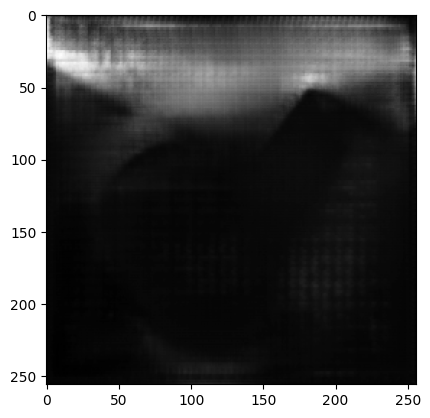

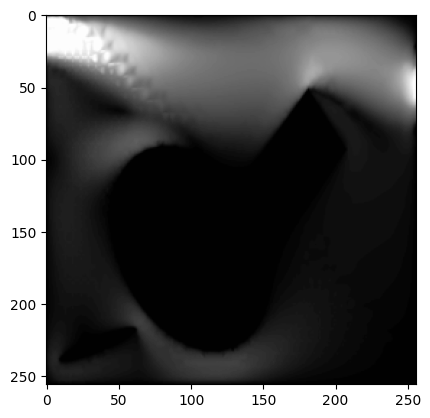

np.float64(1.850868974711143)

In [17]:
paths = [v_mag_img_path_fake, v_mag_img_path_real]
labels = ["Fake", "Real"]
Vs = []

if len(paths) != len(labels):
    print("ERROR: length of labels should be same as length of paths!!!")
    exit(1)

for i, v_mag_img_path in enumerate(paths):
    V = cv2.imread(v_mag_img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    V = V / 255.0

    plt.imshow(V, cmap='gray')
    plt.show()


enhanced_vffd(v_mag_img_path_fake, v_mag_img_path_real)